In [ ]:
"""
Build a linkage map for F2s from a cross between 6024 and 8249.

The assembly for 6024 appears to have a big chunk of chromosome 2 stuck to chromosome 3.
I think this is spurious, but to validate this I want to check whether SNPs on
this arm are in linkage with Chr 2 or Chr 3.

- Get a list of SNP positions in the TAIR10 coordinate system that
    - are inside genes
    - vary between the two parents
    - do not involve a cytosine as either allele
- Select 1000 of these SNPs.
- Extract SNP data on the F2s for families F2.05 and F2.32 from HDF5 files used for validation
    - Filter for only those individuals that were validated as correct.
- Calculate linkage as R^2 for each pair of markers on each chromosome.

"""
import h5py
import re
import pandas as pd
import os
import numpy as np
from glob import glob
import numpy.ma as ma

os.chdir("/groups/nordborg/projects/epiclines/002.pedigree/")

In [36]:
# === Identify segregating SNPs === #

parental_snp_data = h5py.File("03_processing/04_validate_samples/output/parents_genic_SNPs_only.hdf5", mode = 'r')
# Index positions for the data for 8249 and 6024
positions_of_6024_8249 = [ np.where(parental_snp_data['samples'][:] == x)[0][0] for x in [b'6024', b'8249'] ]
# Genotype data for only the parents, masking missing entries
snp_array_of_parents = parental_snp_data['calldata']['GT'][:, positions_of_6024_8249].sum(2)
# snp_array_of_parents = ma.masked_less(snp_array_of_parents, value=0)
# Positions of SNPs that differ between the parents in the HDF5 files, and are not NA.
segregating_snp_ix = (snp_array_of_parents[:,0] != snp_array_of_parents[:,1]) & (snp_array_of_parents[:,0] >=0) & (snp_array_of_parents[:,1] >=0)

In [37]:
# === Select SNPs to use === #

# List of SNP positions that vary between the four accessions and are in genes.
# This is created in 03_processing/04_validate_samples/06_create_parental_VCF.sh
snp_positions = pd.read_csv(
    '03_processing/04_validate_samples/output/variable_SNP_positions.tsv.gz',
    compression='gzip', names=['chr', 'pos', 'alleles'], sep='\t')

# Filter out invariant SNPs, and those involving a cytosine
snp_positions = snp_positions.loc[
    ~snp_positions['alleles'].str.contains('C') & \
    segregating_snp_ix
    ]

# Subset the number of SNPs.
total_n_snps = snp_positions.shape[0]
desired_n_snps = 1000
step_size = np.round(total_n_snps/desired_n_snps)
# Take every nth SNP to give the desired number of SNPs.
snps_ix = np.arange(0, total_n_snps, step_size)
snp_positions = snp_positions.iloc[snps_ix]
# Get the positions of those SNPs in the *index* column
snp_index_ix = list(snp_positions.index)

In [38]:
# To make sure I only use F2 genotype I trust, compare with the table of validated genotypes.
ibd_results = pd.read_csv(
    "03_processing/04_validate_samples/output/ibdpainting_results.csv"
)

# Subset for only those F2s that were in families F2.05 and F2.32 were confirmed as correct. 
ibd_results_for_6024x8249 = ibd_results.loc[
    ibd_results['corrected_plantID'].str.contains("F2.05|F2.32") & \
        (ibd_results['corrected_plantID'] == ibd_results['plantID']) & \
        ~ibd_results['corrected_plantID'].isna()
]
# Get a list of validate F2 names as byte strings (because the HDF5 files use byte strings)
validated_F2_names = ibd_results_for_6024x8249['corrected_plantID'].to_list()
validated_F2_names = [ str.encode(x) for x in validated_F2_names]

len(validated_F2_names)

343

In [57]:
# === SNP data for the F2s === #

# F2 data are distributed over multiple HDF5 files containing plants from many familes.
# For each, import the HDF5 file, and filter by SNP position and sample ID.

# List of HDF5 for F2 generation only (excluding plates with parents, F1s and F3s)
hdf5_file_list = glob("03_processing/04_validate_samples/output/hdf5/2021-0[12]*.hdf5")
# Extract genotype information for each Hdf5 file
snp_matrix_list = []
sample_names_list = []
for hdf5_path in hdf5_file_list:
    with h5py.File(hdf5_path, mode = 'r') as hdf5_for_one_plate:
        # Find the samples in families F2.05 and F2.32
        r=re.compile(b"F2.05|F2.32")
        sample_names_to_keep = list(filter(r.match, hdf5_for_one_plate['samples'][:]))
        # Keep only the samples that were validated
        sample_names_to_keep = [ x for x in sample_names_to_keep if x in validated_F2_names]
        # Get the index positions of those samples
        sample_ix = [ np.where(hdf5_for_one_plate['samples'][:] == x)[0][0] for x in sample_names_to_keep ]
        # Subset by SNP position, then sample, and get the diploid genotype.
        this_matrix = hdf5_for_one_plate['calldata']['GT'][snp_index_ix][:, sample_ix].sum(2)
        # Save the data
        snp_matrix_list.append(this_matrix)
        print(os.path.basename(hdf5_path), ": ", sample_names_to_keep)
        sample_names_list.append(sample_names_to_keep)
# A single matrix with rows for SNPs and columns for samples.
snp_matrix = ma.masked_equal(
    np.hstack(
        tuple(snp_matrix_list)
        ),
    value = -2
)

2021-016.hdf5 :  [b'F2.05.050']
2021-013.hdf5 :  [b'F2.05.002', b'F2.05.003', b'F2.05.004', b'F2.05.005', b'F2.05.006', b'F2.05.007', b'F2.05.008', b'F2.05.009', b'F2.05.010', b'F2.05.012', b'F2.05.013', b'F2.32.001', b'F2.32.002', b'F2.32.003', b'F2.32.004', b'F2.32.005', b'F2.32.006', b'F2.32.007', b'F2.32.008', b'F2.32.009', b'F2.32.010', b'F2.32.011', b'F2.32.012', b'F2.32.013']
2021-018.hdf5 :  [b'F2.05.066', b'F2.05.067', b'F2.05.068', b'F2.05.069', b'F2.05.070', b'F2.05.071', b'F2.05.072', b'F2.05.073', b'F2.05.074', b'F2.05.075', b'F2.05.076', b'F2.05.077', b'F2.05.078', b'F2.32.066', b'F2.32.067', b'F2.32.068', b'F2.32.069', b'F2.32.070', b'F2.32.071', b'F2.32.072', b'F2.32.073', b'F2.32.074', b'F2.32.075', b'F2.32.076', b'F2.32.077', b'F2.32.078']
2021-014.hdf5 :  [b'F2.05.014', b'F2.05.015', b'F2.05.016', b'F2.05.017', b'F2.05.018', b'F2.05.019', b'F2.05.020', b'F2.05.021', b'F2.05.022', b'F2.05.023', b'F2.05.024', b'F2.05.025', b'F2.05.026', b'F2.32.014', b'F2.32.015', b'F2

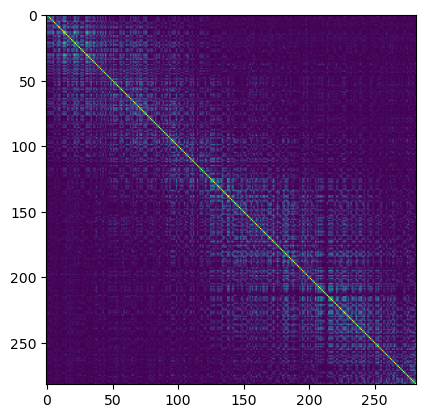

In [63]:
# Plot linkage on a single Chr.
chr = "Chr1"

chr_ix = snp_positions['chr'] == chr
single_chr = snp_matrix[chr_ix]

single_chr = ma.masked_equal(single_chr , -2)

plt.imshow( np.corrcoef(single_chr)**2 )
plt.show()

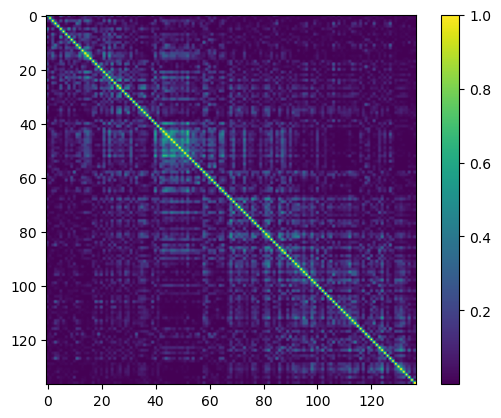

In [ ]:
chr = "Chr2"

chr_ix = snp_positions['chr'] == chr
single_chr = snp_matrix[chr_ix]

single_chr = ma.masked_equal(single_chr , -2)

plt.imshow( np.corrcoef(single_chr)**2 )
plt.colorbar()
plt.show()

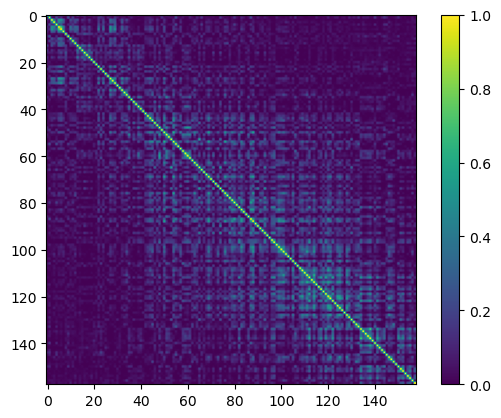

In [ ]:
chr = "Chr3"

chr_ix = snp_positions['chr'] == chr
single_chr = snp_matrix[chr_ix]

single_chr = ma.masked_equal(single_chr , -2)

plt.imshow( np.corrcoef(single_chr)**2 )
plt.colorbar()
plt.show()

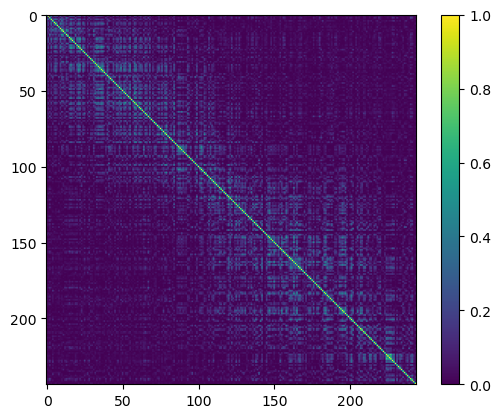

In [68]:
chr = "Chr5"

chr_ix = snp_positions['chr'] == chr
single_chr = snp_matrix[chr_ix]

single_chr = ma.masked_equal(single_chr , -2)

plt.imshow( np.corrcoef(single_chr)**2 )
plt.colorbar()
plt.show()

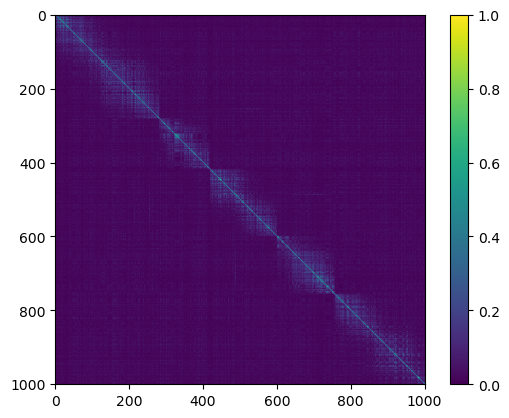

In [ ]:
# Linkage across the whole genome.
plt.imshow( np.corrcoef(snp_matrix)**2 )
plt.colorbar()
plt.show()

/home/thomas.ellis/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/thomas.ellis/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


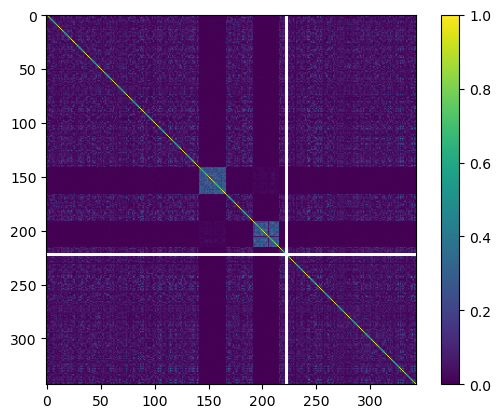

In [ ]:
# Transpose the matrix to show correlations between individuals
# Somewhat alarmingly plates 2021-019 and 2021-023 look strange.
plt.imshow( np.corrcoef(snp_matrix.T)**2 )
plt.colorbar()
plt.show()